In [4]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import torch
import clip
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
import os
total_images = 0
base_dir = r"/Users/fatimatuzzahra/Downloads/processed_slices/train"

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith('.png'):
            total_images += 1

print("Total images in testing folder:", total_images)


Total images in testing folder: 84825


In [7]:
class MLPWithDropout(nn.Module):
    def __init__(self, input_dim):
        super(MLPWithDropout, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

# Example usage:
input_dim = X_train.shape[1]
model = MLPWithDropout(input_dim).to(device)

Epoch 1/100, Train Loss: 0.6575, Val Loss: 0.6680
Epoch 2/100, Train Loss: 0.5628, Val Loss: 0.6328
Epoch 3/100, Train Loss: 0.4513, Val Loss: 0.6306
Epoch 4/100, Train Loss: 0.3553, Val Loss: 0.6407
Epoch 5/100, Train Loss: 0.2803, Val Loss: 0.6462
Epoch 6/100, Train Loss: 0.2226, Val Loss: 0.7210
⏹️ Early stopping triggered at epoch 6
📊 Training Accuracy: 0.9853
✅ Validation Accuracy: 0.6900
Classification Report:
               precision    recall  f1-score   support

     Not MCI       0.73      0.67      0.69      4455
         MCI       0.66      0.72      0.69      3960

    accuracy                           0.69      8415
   macro avg       0.69      0.69      0.69      8415
weighted avg       0.69      0.69      0.69      8415



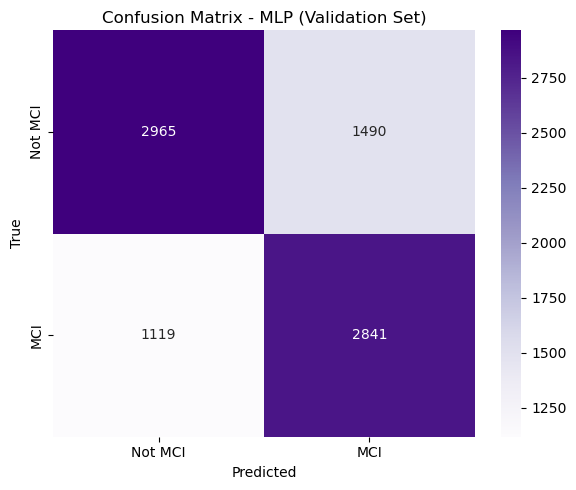

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import torch.nn as nn
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
import torch 
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Load data
X_train = np.load("train_fused_features_clean.npy")
y_train = np.load("train_fused_labels_clean.npy")
X_val = np.load("val_fused_features_clean.npy")
y_val = np.load("val_fused_labels_clean.npy")

y_train = np.where(y_train == 2, 1, 0)
y_val = np.where(y_val == 2, 1, 0)

# Optional: if your MLP has 1024 input, pad image/text features accordingly
# assert X_train.shape[1] == 1024

# Scale inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_bal, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_bal, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)



input_dim = X_train.shape[1]  # or manually set to 256 for image-only
model = MLPWithDropout(input_dim).to(device).to("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Early stop[ping variables
num_epochs = 100
patience = 3  # how many epochs to wait before early stopping

train_losses = []
val_losses = []

best_val_loss = float("inf")
early_stop_epoch = -1
epochs_no_improve = 0
best_model_state = None



for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---------------- Validation and Early Stopping ----------------
    model.eval()
    val_loss = 0.0
    y_val_preds = []
    y_val_true = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb.unsqueeze(1).float())
            val_loss += loss.item()
            preds = (torch.sigmoid(out).squeeze() > 0.5).int()
            y_val_preds.extend(preds.cpu().numpy())
            y_val_true.extend(yb.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        early_stop_epoch = epoch
        best_model_state = model.state_dict()

    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop_epoch = epoch  # ⏹️ Where stopping actually happens
            print(f"⏹️ Early stopping triggered at epoch {epoch+1}")
            break
# 🔹 Evaluate on Training Set
model.eval()
y_train_preds = []
y_train_true = []
with torch.no_grad():
    for xb, yb in train_loader:
        xb = xb.to(device)
        out = model(xb)
        preds = (torch.sigmoid(out).squeeze() > 0.5).int()  
        y_train_preds.extend(preds.cpu().numpy())
        y_train_true.extend(yb.numpy())

    # Training Metrics
    train_acc = accuracy_score(y_train_true, y_train_preds)
    print(f"📊 Training Accuracy: {train_acc:.4f}")

# Restore best model
model.load_state_dict(best_model_state)

# Final evaluation on validation set
val_acc = accuracy_score(y_val_true, y_val_preds)
print(f"✅ Validation Accuracy: {val_acc:.4f}")
print("Classification Report:\n", classification_report(y_val_true, y_val_preds, target_names=["Not MCI", "MCI"]))

cm = confusion_matrix(y_val_true, y_val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["Not MCI", "MCI"], yticklabels=["Not MCI", "MCI"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MLP (Validation Set)")
plt.tight_layout()
plt.show()

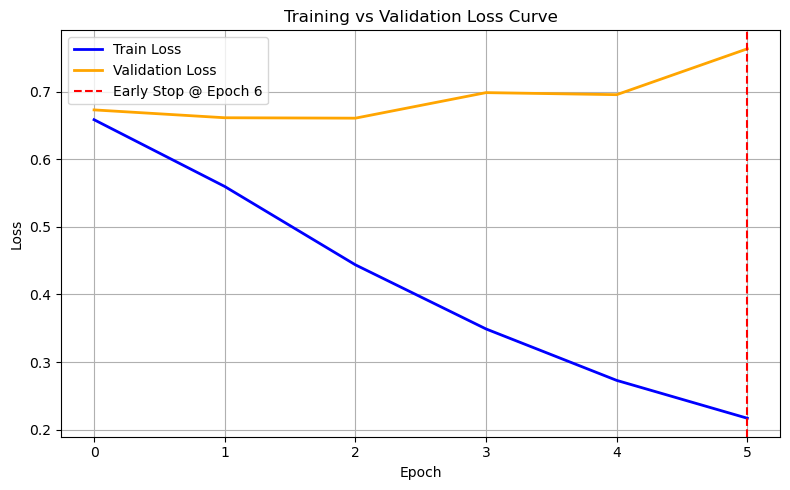

In [15]:
# Loss Curve with Early Stopping Marker
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)

# Mark early stopping epoch
if early_stop_epoch != -1:
    plt.axvline(early_stop_epoch, color='red', linestyle='--', label=f"Early Stop @ Epoch {early_stop_epoch+1}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()